# <font color = 'Red'> **Desafio de Dados**</font> $→$ <font color = 'GREY'> **FieldPRO**</font>


## <font color='Blue'> **1° Entender o Problema de Negócio**  </font>

#### <font color = 'Chocolate'> **Objetivio**</font>
- *O objetivo deste desafio é construir um modelo de calibração de um sensor de chuva baseado em impactos mecânicos*.

####  <font color = 'Chocolate'> **Descrição do problema**</font>


O sistema de medição de chuva funciona por meio de uma placa eletrônica com um piezoelétrico, um acumulador de carga e um sensor de temperatura. Os dados são transmitidos de hora em hora.

O impacto das gotas de chuva gera vibrações no piezoelétrico, que induzem uma corrente elétrica. A corrente elétrica não é medida diretamente, mas é acumulada ao longo do tempo e gera uma queda na carga do acumulador.

A carga do acumulador é medida de hora em hora e transmitida com o
nome de `piezo_charge`. A temperatura da placa é transmitida sob o nome
`piezo_temperature` e pode ser importante na calibração.

Um evento de reset na placa pode afetar o comportamento do acumulador de
carga, e o número total de resets da placa desde que foi ligada pela primeira vez é transmitido com o nome `num_of_resets`.

As medidas realizadas pelo sensor estão no arquivo `Sensor_FieldPRO`.csv, para comparação, foram utilizadas medidas de uma estação metereológica próxima, que estão no arquivo `Estacao_Convencional.csv`.

Outras medidas que podem ser úteis na modelagem são: a temperatura do ar externo `air_temperature_100`, umidade relativa do ar externo `air_humidity_100` e a pressão atmosférica `atm_pressure_main`.

As medidas do sensor incluem a carga medida no acumulador, a temperatura da placa, o número de resets da placa e as condições atmosféricas do ambiente.

**Bônus:** *Realizar o deploy do modelo em uma plataforma de cloud.
Boa Sorte!*

#### <font color = 'Chocolate'> **Descrição das Variáveis em mabas as bases de Dados**</font>

- **piezo_charge.** $→$ *Carga do acumulador*

- **piezo_temperature** $→$ *Temperatura da placa*

- **num_of_resets.** $→$ *Número total de resets da placa*

- **air_humidity_100** $→$ *Umidade relativa do ar externo*

- **air_temperature_100** $→$ *Temperatura do ar externo*

- **atm_pressure_main** $→$ *Pressão atmosférica*

- **Hora (Brasília)** $→$ *Fuso horário* (hora)
- **Datetime – utc** $→$ *Data*
- **chuva** $→$ *Chuva*

## <font color='Blue'> **2° Entendendo os Dados**  </font> $ →$ <font color='Black'> *Análise Exploratória de Dados (EDA)*  </font>



#### **Bibliotecas**

In [2]:
# Importando as Bibliotecas e Funções Necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

# Configurações de Ambiente
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_theme(color_codes=True)

# Ignorando Alertas
import warnings
warnings.filterwarnings("ignore")

# Exibindo os gráfico nesse Notebook
%matplotlib inline

 #### **Importando os Dados**

In [3]:
df_sensor = pd.read_csv('Sensor_FieldPRO.csv')
df_estacao = pd.read_csv('Estacao_Convencional.csv')

##### **Visualizando os Dados**

In [4]:
df_sensor.head()

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,2020-09-30T23:00:00Z,38.00,31.37,9412,0,45123,30
1,2020-10-01T00:00:00Z,NaN,NaN,9412,0,45025,31
2,2020-10-01T01:00:00Z,39.00,31.37,9419,0,44923,31
3,2020-10-01T02:00:00Z,39.00,31.32,9419,0,44825,31
4,2020-10-01T03:00:00Z,38.00,31.24,9416,0,44728,31


- **Verificando informações dos dados**

In [5]:
df_sensor.shape

(1711, 7)

In [6]:
df_sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datetime – utc       1711 non-null   object 
 1   air_humidity_100     1705 non-null   float64
 2   air_temperature_100  1705 non-null   float64
 3   atm_pressure_main    1711 non-null   int64  
 4   num_of_resets        1711 non-null   int64  
 5   piezo_charge         1711 non-null   int64  
 6   piezo_temperature    1711 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 93.7+ KB


In [7]:
df_sensor.dtypes

Datetime – utc          object
air_humidity_100       float64
air_temperature_100    float64
atm_pressure_main        int64
num_of_resets            int64
piezo_charge             int64
piezo_temperature        int64
dtype: object

In [8]:
df_estacao.head()

,data,Hora (Brasília),chuva
0,2020-09-01,00:00:00,0.00
1,2020-09-01,01:00:00,0.00
2,2020-09-01,02:00:00,0.00
3,2020-09-01,03:00:00,0.00
4,2020-09-01,04:00:00,0.00


In [9]:
df_estacao.shape

(2256, 3)

In [10]:
df_estacao.dtypes

data                object
Hora (Brasília)     object
chuva              float64
dtype: object

##### **Verificando valores ausentes**

In [11]:
def missingvalue(data):
    missing_value = data.isnull().sum(axis=0).reset_index()
    missing_value.columns = ['variable', 'number_of_missing']
    missing_value['percentage_of_missing'] = (missing_value['number_of_missing']) / data.shape[0] * 100
    mv = missing_value.sort_values('percentage_of_missing', ascending=False).reset_index(drop=True)
    
    # Formata a coluna 'percentage_of_missing' com o símbolo de porcentagem
    mv['percentage_of_missing'] = mv['percentage_of_missing'].apply(lambda x: f'{x:.2f}%')
    
    return mv

df_missing_sensor = missingvalue(df_sensor)
df_missing_sensor

,variable,number_of_missing,percentage_of_missing
0,air_humidity_100,6,0.35%
1,air_temperature_100,6,0.35%
2,Datetime – utc,0,0.00%
3,atm_pressure_main,0,0.00%
4,num_of_resets,0,0.00%
5,piezo_charge,0,0.00%
6,piezo_temperature,0,0.00%


In [12]:
def missingvalue(data):
    missing_value = data.isnull().sum(axis=0).reset_index()
    missing_value.columns = ['variable', 'number_of_missing']
    missing_value['percentage_of_missing'] = (missing_value['number_of_missing']) / data.shape[0] * 100
    mv = missing_value.sort_values('percentage_of_missing', ascending=False).reset_index(drop=True)
    
    # Formata a coluna 'percentage_of_missing' com o símbolo de porcentagem
    mv['percentage_of_missing'] = mv['percentage_of_missing'].apply(lambda x: f'{x:.2f}%')
    
    return mv

df_missing_estacao = missingvalue(df_estacao)
df_missing_estacao 


,variable,number_of_missing,percentage_of_missing
0,data,0,0.00%
1,Hora (Brasília),0,0.00%
2,chuva,0,0.00%


**Considerações**

- Pode-se observar que temos menos que $1$% de valores ausente na base dedados `df_senor` para as colunas **air_humidity_100** e  **air_temperature_100**, por esse motivos vamos exclui-los da nossa base de dados.

In [13]:
df_sensor.dropna(inplace=True)
df_sensor.isnull().sum()

Datetime – utc         0
air_humidity_100       0
air_temperature_100    0
atm_pressure_main      0
num_of_resets          0
piezo_charge           0
piezo_temperature      0
dtype: int64

#### **Juntando as Bases**
- Excluindo algumas colunas que não apresentam grande impacto no modelo

In [14]:
df = pd.concat([df_sensor, df_estacao], axis=1)
df = df.drop(columns=['Datetime – utc', 'data', 'Hora (Brasília)'], axis=1)
df.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
0,38.00,31.37,9412.00,0.00,45123.00,30.00,0.00
2,39.00,31.37,9419.00,0.00,44923.00,31.00,0.00
3,39.00,31.32,9419.00,0.00,44825.00,31.00,0.00
4,38.00,31.24,9416.00,0.00,44728.00,31.00,0.00
5,39.00,30.83,9411.00,0.00,44632.00,30.00,0.00


#### *Eliminando Duplicidade e Valores ausentes adicionados na EDA*

In [15]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
0,38.00,31.37,9412.00,0.00,45123.00,30.00,0.00
2,39.00,31.37,9419.00,0.00,44923.00,31.00,0.00
3,39.00,31.32,9419.00,0.00,44825.00,31.00,0.00
4,38.00,31.24,9416.00,0.00,44728.00,31.00,0.00
5,39.00,30.83,9411.00,0.00,44632.00,30.00,0.00


In [16]:
df.shape

(1705, 7)

- **Salvando a base de dados limpa**

In [17]:
# Salvando o DataFrame como arquivo CSV
nome_arquivo_csv = 'df_clear.csv'
df.to_csv(nome_arquivo_csv, index=False)

#### **Análise Matemática** - Estatística Descritiva

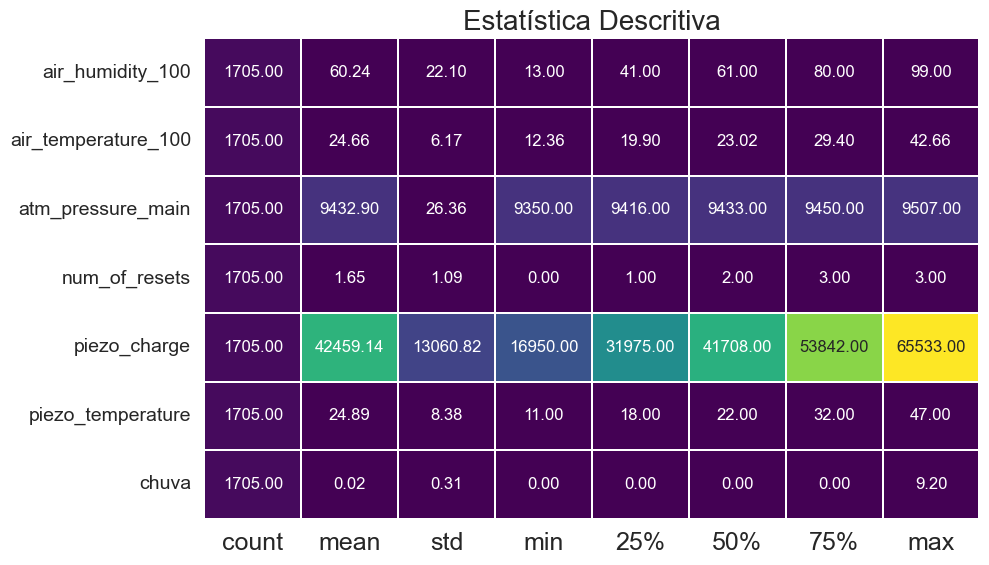

In [18]:
def plot_heatmap(dataframe):
    f, ax = plt.subplots(figsize=(10, dataframe.shape[1]*0.78))
    sns.heatmap(dataframe,
                annot=True,
                cmap="viridis",
                fmt='.2f',
                ax=ax,
                linecolor='white',
                linewidths=1.3,
                cbar=False,
                annot_kws={"size": 12})
    plt.xticks(size=18)
    plt.yticks(size=14, rotation=0)
    plt.title("Estatística Descritiva", size=20)
    plt.show()

def desc_stats(dataframe):
    desc = dataframe.describe().T
    plot_heatmap(desc)

desc_stats(df.select_dtypes(include=[np.number]))


#### **Criando algumas Visualizações**

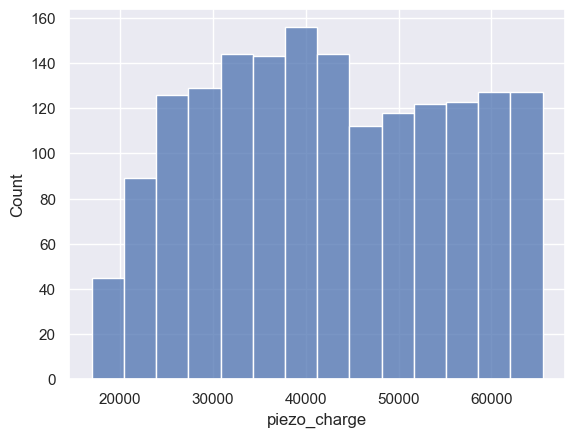

In [19]:
# Analisando as distribuições do índice de massa corporal
sns.set_style("darkgrid")
plt.tight_layout()

sns.histplot(data=df, x='piezo_charge');

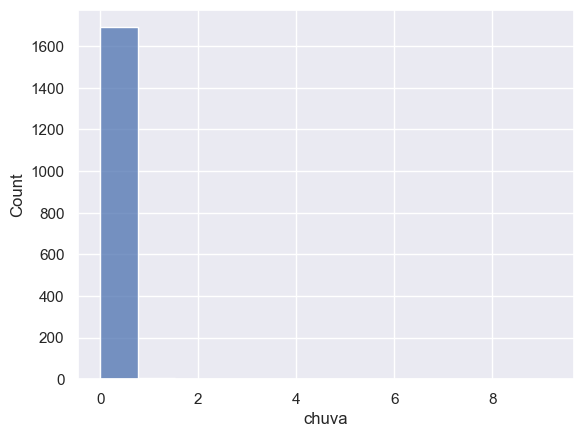

In [20]:
# Analisando a variável target: valor do seguro
sns.histplot(data=df['chuva']);

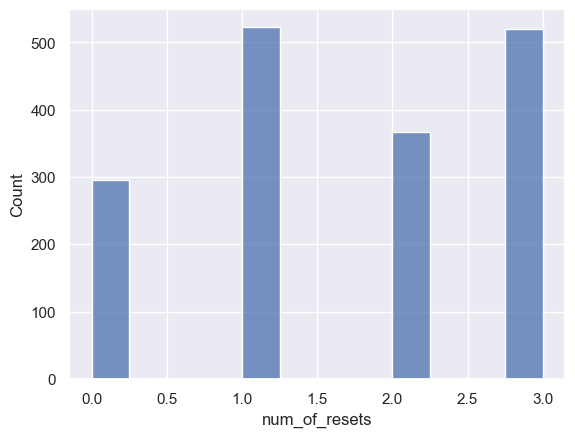

In [21]:
# Analisando a variável target: valor do seguro
sns.histplot(data=df['num_of_resets']);

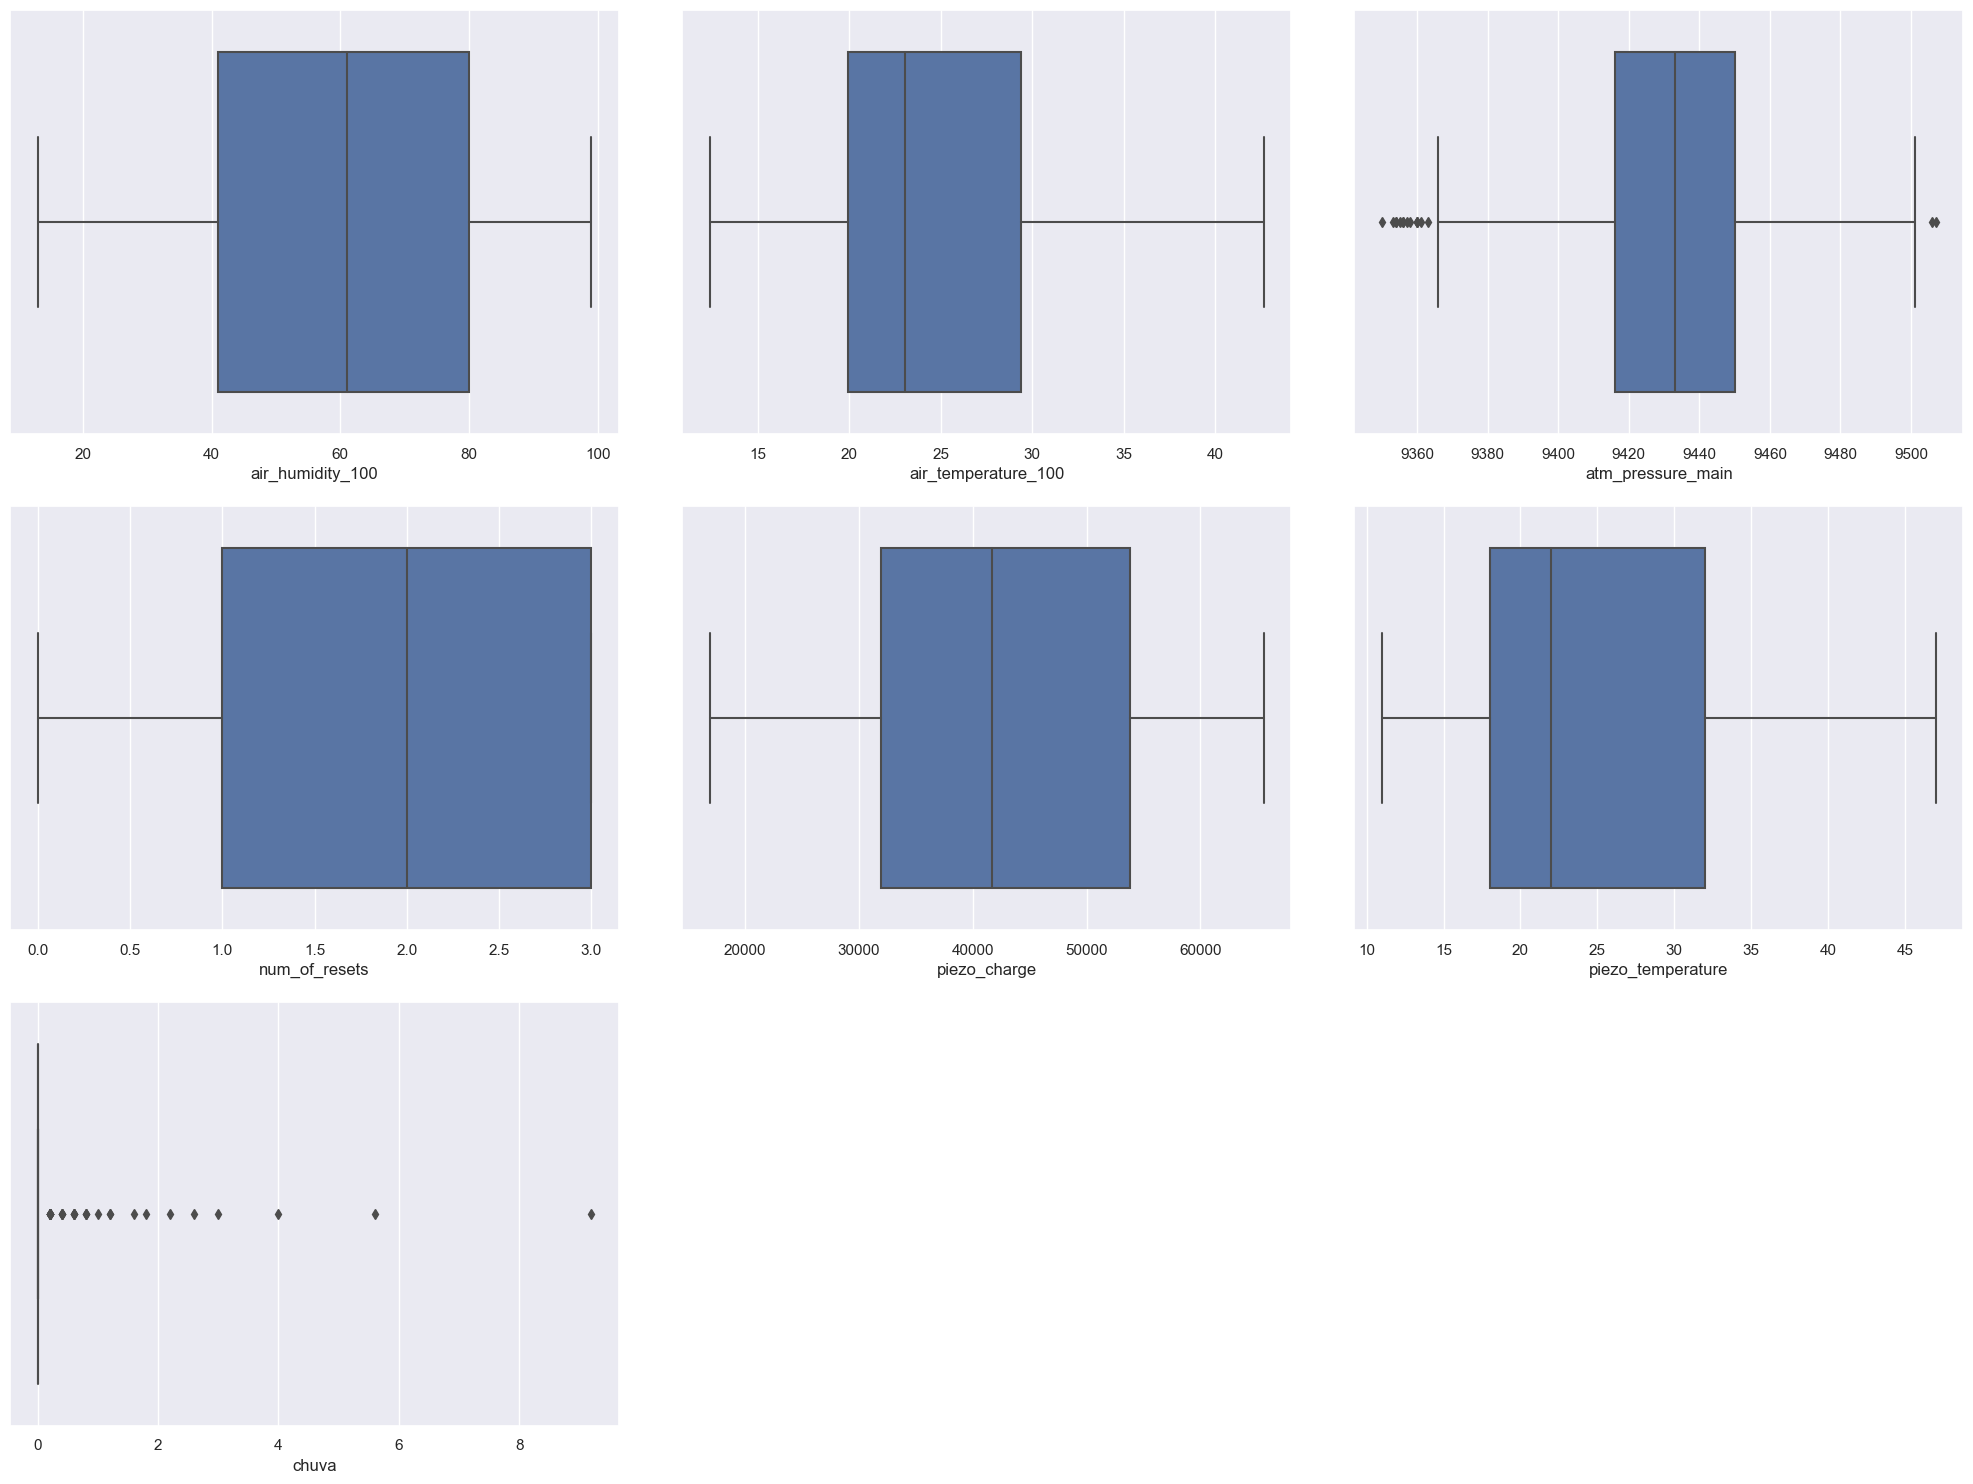

In [22]:
def plot_numerical_variables_boxplot(df):
    # list of numerical variables to plot
    num_vars = df.select_dtypes(include=[np.number])

    # create figure with subplots
    num_cols = len(num_vars.columns)
    num_rows = (num_cols + 2) // 3
    fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, 5*num_rows))
    axs = axs.flatten()

    # create violinplot for each numerical variable
    for i, var in enumerate(num_vars):
        sns.boxplot(x=var, data=df, ax=axs[i])

    # adjust spacing between subplots
    fig.tight_layout()

    # remove any extra subplots
    if num_cols < len(axs):
        for i in range(num_cols, len(axs)):
            fig.delaxes(axs[i])

    plt.show();

    # Chamada da função
plot_numerical_variables_boxplot(df)

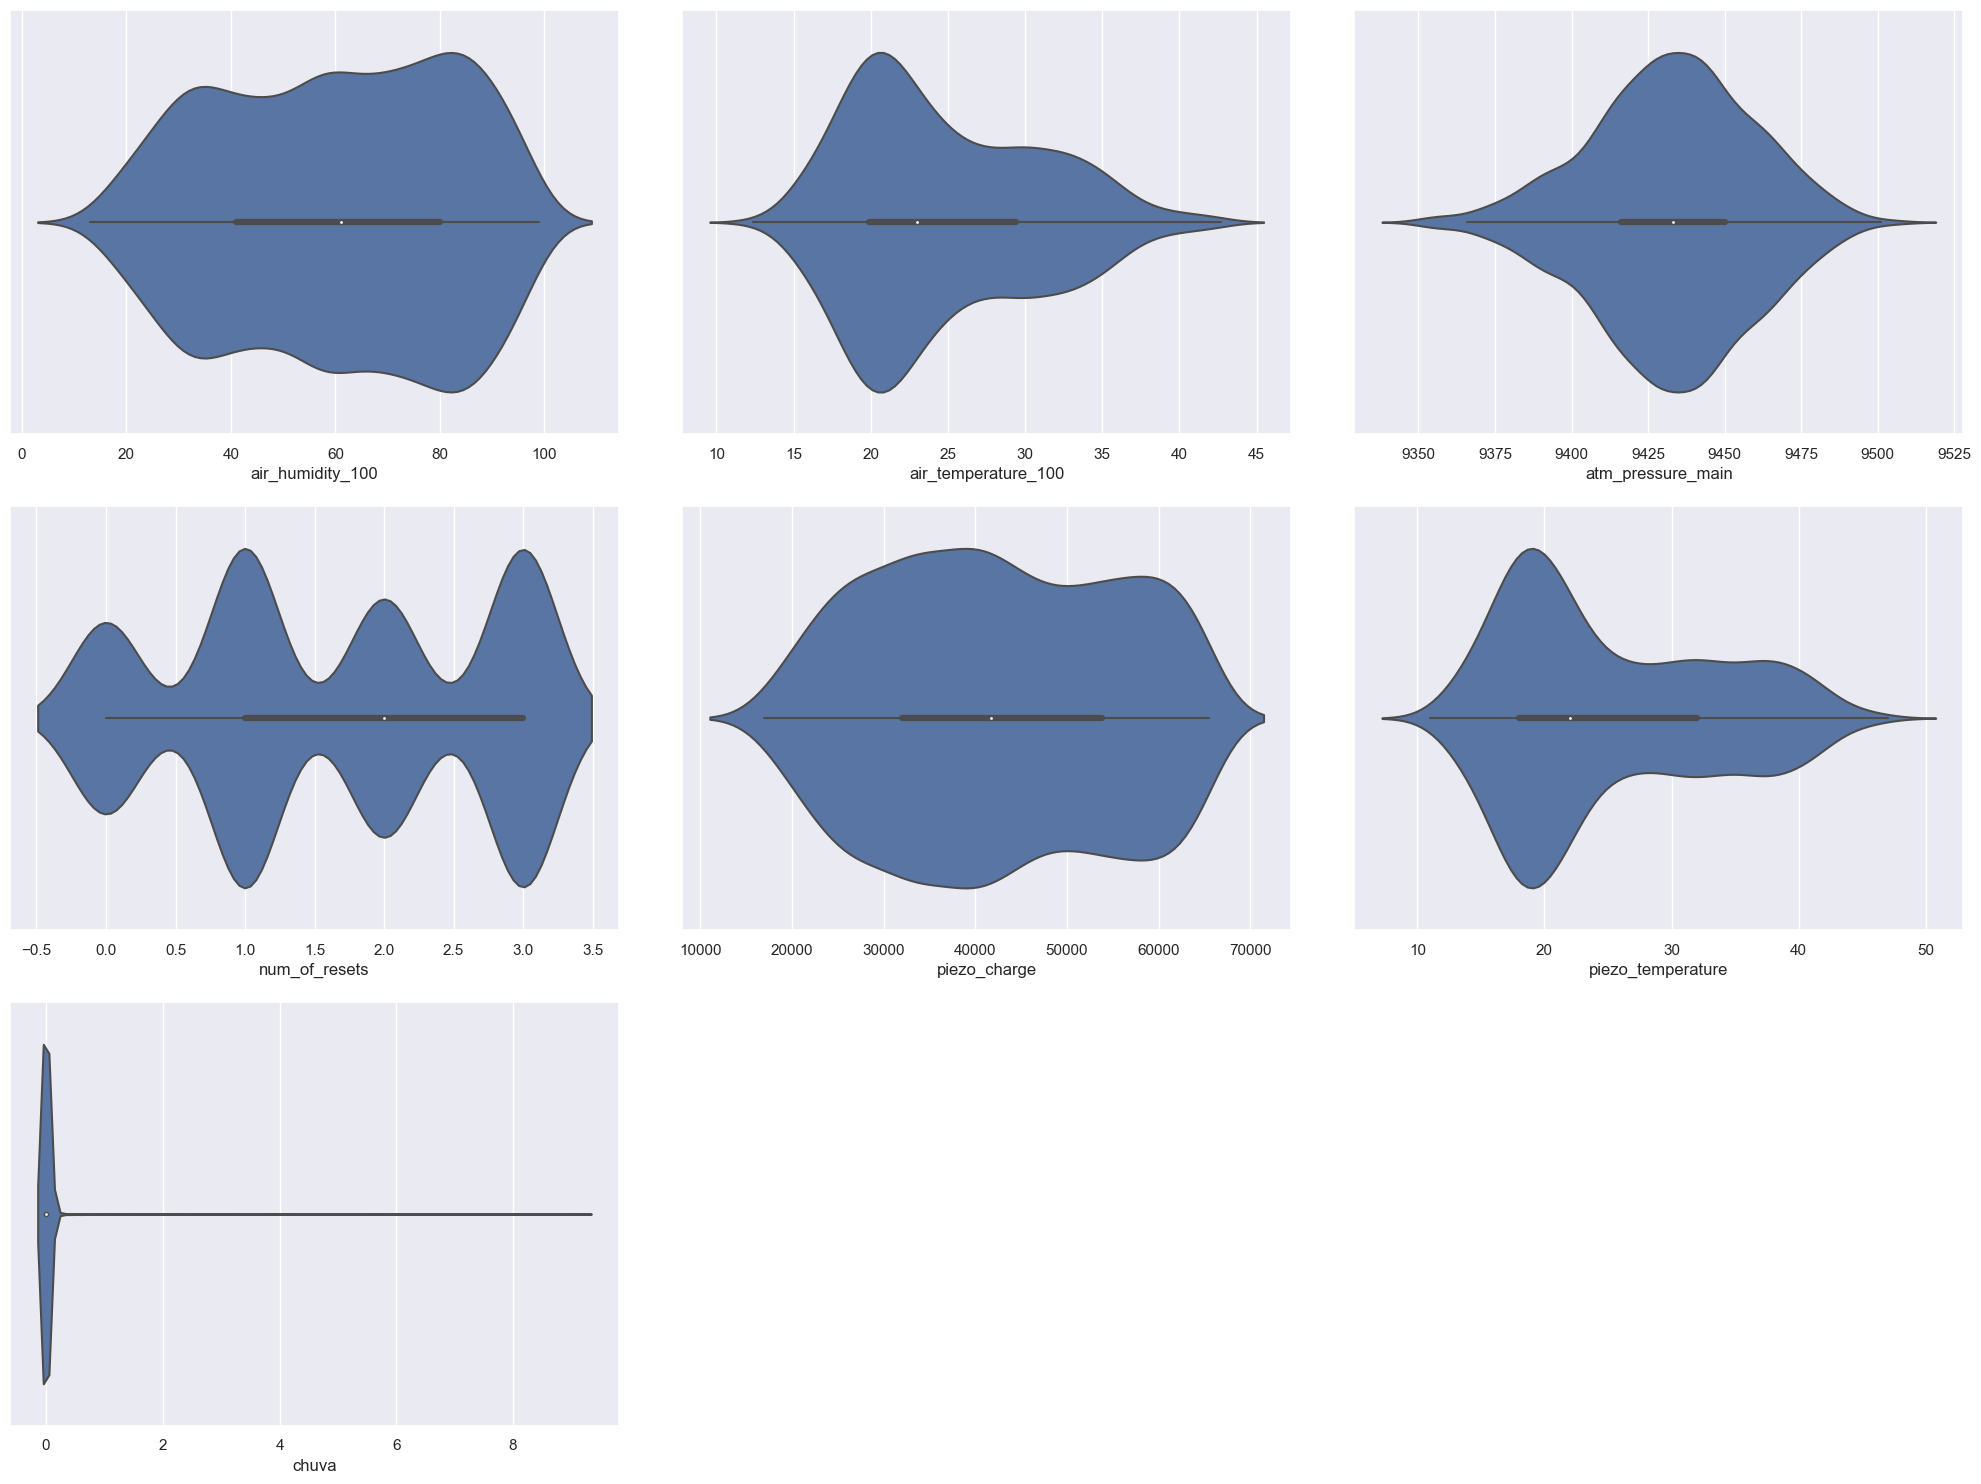

In [23]:
def plot_numerical_variables_violin(df):
    # list of numerical variables to plot
    num_vars = df.select_dtypes(include=[np.number])

    # create figure with subplots
    num_cols = len(num_vars.columns)
    num_rows = (num_cols + 2) // 3
    fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, 5*num_rows))
    axs = axs.flatten()

    # create violinplot for each numerical variable
    for i, var in enumerate(num_vars):
        sns.violinplot(x=var, data=df, ax=axs[i])

    # adjust spacing between subplots
    fig.tight_layout()

    # remove any extra subplots
    if num_cols < len(axs):
        for i in range(num_cols, len(axs)):
            fig.delaxes(axs[i])

    plt.show();

    # Chamada da função
plot_numerical_variables_violin(df)

## <font color='Blue'> **3° Preparação dos Dados**  </font> $ →$ <font color='Black'> *Pré-Processamento*  </font>

##### **Analisando a Correlação entre as variáveis**

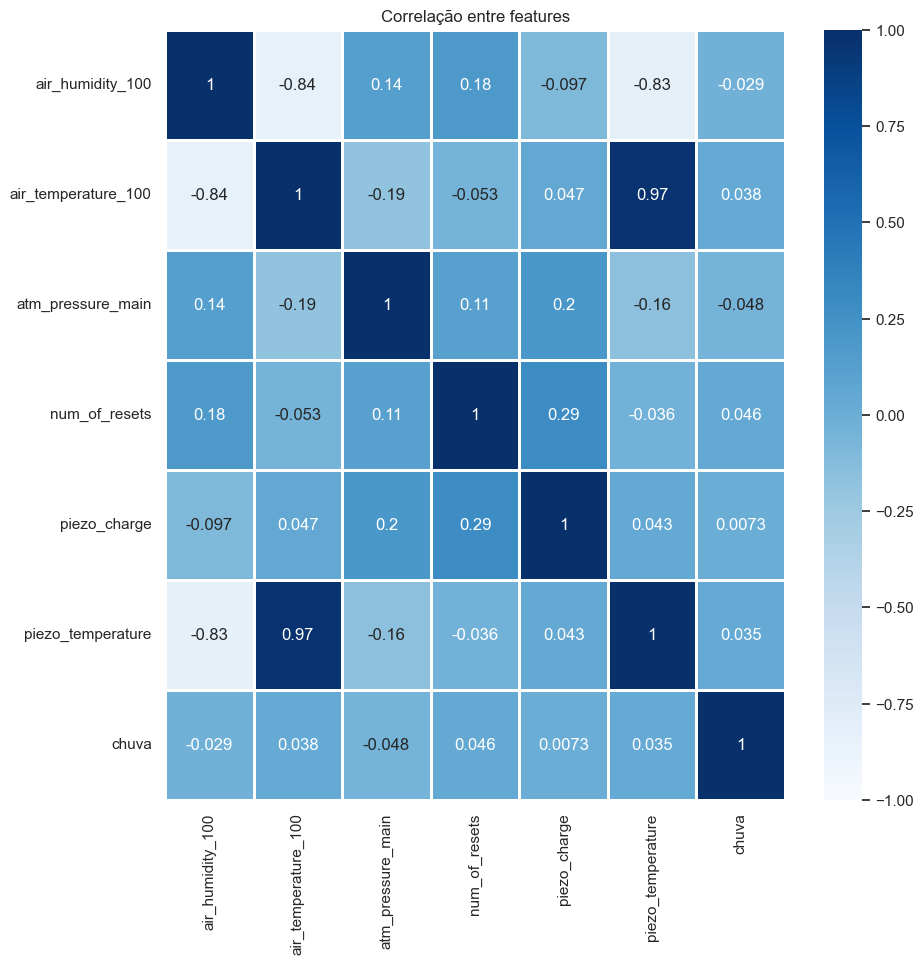

In [24]:
corr = df.corr()
plt.figure(figsize = (10, 10))
plt.title('Correlação entre features')
sns.heatmap(corr,
            cmap = 'Blues',
            annot = True,
            vmin=-1,
            vmax=1,
            linewidths=2
           );

- **Filtrando as Variáveis com correlação superior que $85$%**

In [25]:
p = 0.85 # correlação mínima
var = []
for i in corr.columns:
    for j in corr.columns:
        if(i != j):
            if np.abs(corr[i][j]) > p: # se for maior do que |p|
                var.append([i,j])
print('As Variáveis mais correlacionadas são → {}'.format(var))

As Variáveis mais correlacionadas são → [['air_temperature_100', 'piezo_temperature'], ['piezo_temperature', 'air_temperature_100']]


**Considerações**

- Pode-se observar que temos uma alta correlação entre as variáveis:

  - *air_temperature_100*

  - *piezo_temperature*

- Essas variáveis estão altamente correlaciondas, e isso pode nos gerar um problema conehcido como *multicollinearity*. Para resolver esse problema, vamos eliminar uma delas. Nesse caso, vamos eliminar a variável **piezo_temperature** dos nossos dados, porque não podemos permanecer com as duas variáveis visto que estão tratando de um problema de regressão.

In [26]:
df.drop(columns=['piezo_temperature'], axis=1, inplace=True)
df.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,chuva
0,38.00,31.37,9412.00,0.00,45123.00,0.00
2,39.00,31.37,9419.00,0.00,44923.00,0.00
3,39.00,31.32,9419.00,0.00,44825.00,0.00
4,38.00,31.24,9416.00,0.00,44728.00,0.00
5,39.00,30.83,9411.00,0.00,44632.00,0.00


#### **Separando as variáveis em Independentes e dependente**:

- **Preditoras** *(Variáveis Independentes)* $→$ $(X)$

- **Target** *(Variável dependente)* $→$ $(y)$

Ou seja, vamos definir quem é o $X$ e quem é o $y$.

In [27]:
# Sperando em X e y
X = df.drop('chuva', axis=1)
y = df[['chuva']]

In [28]:
# Visualizando as variáveis preditoras
X.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge
0,38.00,31.37,9412.00,0.00,45123.00
2,39.00,31.37,9419.00,0.00,44923.00
3,39.00,31.32,9419.00,0.00,44825.00
4,38.00,31.24,9416.00,0.00,44728.00
5,39.00,30.83,9411.00,0.00,44632.00


In [29]:
# Visualizando a variável dependente
y.head()

,chuva
0,0.00
2,0.00
3,0.00
4,0.00
5,0.00


### **Separando os dados em**:

- *Dados de treino*

- *Dados de teste*

In [30]:
# Devolve uma tupla com 4 elementos: X de treino, X de teste, y de treino, y de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, # preditoras
                                                        y, # target
                                                        test_size=.2,
                                                        random_state=42)

# Vamos ver quantas linhas ficamos com treino e teste
X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

((1364, 5), (341, 5), (1364, 1), (341, 1))

### <font color = 'Chocol'> **Normalizando os Dados**</font>
- **A normalização é quando os dados estão no intervalo entre** $0$ e $1$

In [31]:
# Criar scaler
scaler = MinMaxScaler()

colunas = X_treino.columns

# Parte importante!! Fit no treino! Transform no treino e teste
X_treino[colunas] = scaler.fit_transform(X_treino)
X_teste[colunas] = scaler.transform(X_teste)

X_treino.shape, X_teste.shape

((1364, 5), (341, 5))

In [32]:
X_treino.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge
1202,0.85,0.11,0.60,1.00,0.99
428,0.56,0.31,0.45,0.33,0.79
1674,0.62,0.30,0.50,1.00,0.13
581,0.84,0.23,0.37,0.33,0.52
554,0.80,0.28,0.49,0.33,0.56


In [33]:
X_treino.describe()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge
count,1364.00,1364.00,1364.00,1364.00,1364.00
mean,0.55,0.40,0.53,0.56,0.53
std,0.26,0.20,0.17,0.36,0.27
min,0.00,0.00,0.00,0.00,0.00
25%,0.33,0.25,0.42,0.33,0.31
50%,0.56,0.35,0.53,0.67,0.51
75%,0.78,0.56,0.64,1.00,0.76
max,1.00,1.00,1.00,1.00,1.00


In [34]:
X_teste.describe()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge
count,341.00,341.00,341.00,341.00,341.00
mean,0.55,0.41,0.54,0.53,0.52
std,0.25,0.20,0.17,0.36,0.27
min,0.01,0.01,0.04,0.00,0.01
25%,0.33,0.25,0.43,0.33,0.30
50%,0.58,0.37,0.55,0.33,0.50
75%,0.76,0.56,0.65,1.00,0.76
max,0.98,1.00,1.01,1.00,1.00


## <font color='Blue'> **4° Modelagem**</font> $ →$ <font color='Black'> *Construção e a escolha do melhor do Modelo*  </font>

#### <font color='DeepSkyBlue'> **Construção e a escolha do melhor do Modelo**  </font>

- Vamos treinar dois modelos.

- Iremos utilizar **cross validation** para escolher o melhor modelo de forma a evitarmos o `overfit` e termos uma base boa para fazermos a  comparação entre os modelos

### <font color='DeepSky'> **Random Forest Regressor**  </font>


In [35]:
# Criando o estimador, algorimo, modelo, preditor, regressor (virge, que tanto de nome!)
rf = RandomForestRegressor()

# Vamos treinar utilizando cross validation
valores_rmse_rf = cross_val_score(estimator=rf,
                                  X=X_treino,
                                  y=y_treino,
                                  cv=10, # 10-fold CV
                                  scoring='neg_root_mean_squared_error')
valores_rmse_rf

array([-0.31690741, -0.19117073, -0.70246205, -0.09819748, -0.73296439,
       -0.2698875 , -0.18774866, -0.26417892, -0.09246128, -0.17682968])

In [36]:
valores_rmse_rf = valores_rmse_rf * -1
valores_rmse_rf

array([0.31690741, 0.19117073, 0.70246205, 0.09819748, 0.73296439,
       0.2698875 , 0.18774866, 0.26417892, 0.09246128, 0.17682968])

In [37]:
valores_rmse_rf = valores_rmse_rf.mean()
valores_rmse_rf

0.30328080951141356

### <font color='DeepSky'> **Decision Tree Regressor**  </font>

In [38]:
dtree = DecisionTreeRegressor()

# Vamos treinar utilizando cross validation (sempre!!)
valores_rmse_dtree = cross_val_score(estimator=dtree,
                                      X=X_treino,
                                      y=y_treino,
                                      cv=10, #
                                  scoring='neg_root_mean_squared_error')
valores_rmse_dtree

array([-0.36085867, -0.31967136, -0.6186871 , -0.13776103, -0.68190908,
       -0.56853786, -0.27759471, -0.36622076, -0.0420084 , -0.35355339])

In [39]:
valores_rmse_dtree = valores_rmse_dtree * -1
valores_rmse_dtree

array([0.36085867, 0.31967136, 0.6186871 , 0.13776103, 0.68190908,
       0.56853786, 0.27759471, 0.36622076, 0.0420084 , 0.35355339])

In [40]:
valores_rmse_dtree = valores_rmse_dtree.mean()
valores_rmse_dtree

0.37268023686509155

### <font color='Dee'> **Comparando os modelos**  </font>

In [41]:
rmse_data = {
    'Modelos': ['Random Forest', 'Decision Tree'],
    'RMSE': [valores_rmse_rf, valores_rmse_dtree]
}

rmse_df = pd.DataFrame(rmse_data)
rmse_df

,Modelos,RMSE
0,Random Forest,0.30
1,Decision Tree,0.37


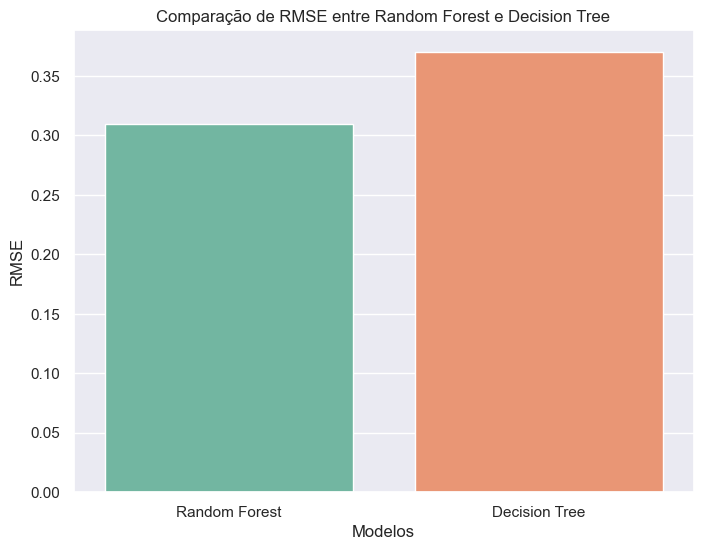

In [42]:
data = {
    'Modelos': ['Random Forest', 'Decision Tree'],
    'RMSE': [0.31, 0.37]
}

df = pd.DataFrame(data)

# Visualizando em um Gráfico de Barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Modelos', y='RMSE', data=df, palette='Set2')
plt.xlabel('Modelos')
plt.ylabel('RMSE')
plt.title('Comparação de RMSE entre Random Forest e Decision Tree')
plt.show()

## <font color='Blue'> **5° Avaliação**</font> $ →$ <font color='Black'> *Avaliação dos Resultados dos Modelos*  </font>

**Considerações**

- Como pode-se observar o modelo campeão foi o **Random Forest Regressor**

  - *Agora vamos treinar o nosso modelo utilizando a base de treino toda!*

- *Depois que nosso modelo for terinado podemos fazer inferências dos valores do **Sensor de Chuva** no dados de teste*.

In [43]:
# Treinando o modelo
rf.fit(X_treino, y_treino)

sensor_predito = rf.predict(X_teste)
sensor_predito[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [44]:
len(sensor_predito)

341

In [45]:
y_teste.head()

,chuva
1052,0.00
751,0.00
791,0.00
373,0.00
1035,0.00


##### **Criando um DataFrame de comparação**

In [46]:
predicoes_vs_real = pd.DataFrame({'predicao': sensor_predito.flatten(), 'real': y_teste.values.flatten()})
predicoes_vs_real['diferenca_abs'] = abs(predicoes_vs_real['predicao'] - predicoes_vs_real['real'])
predicoes_vs_real.head(15)

,predicao,real,diferenca_abs
0,0.00,0.00,0.00
1,0.00,0.00,0.00
2,0.00,0.00,0.00
3,0.00,0.00,0.00
4,0.00,0.00,0.00
5,0.00,0.00,0.00
6,0.00,0.00,0.00
7,0.00,0.00,0.00
8,0.00,0.00,0.00
9,0.00,0.00,0.00


##### **Visualizando o valor das metricas**

In [47]:
y_pred = rf.predict(X_teste)
mae = mean_absolute_error(y_teste, y_pred)
mape = mean_absolute_percentage_error(y_teste, y_pred)
mse = mean_squared_error(y_teste, y_pred)
r2 = r2_score(y_teste, y_pred)
rmse = math.sqrt(mse)

print('MAE is {}'.format(mae))
print('MAPE is {}'.format(mape))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
print('RMSE score is {}'.format(rmse))

MAE is 0.03143108504398827
MAPE is 104256350318072.45
MSE is 0.023151964809384157
R2 score is -2.2329397876837342
RMSE score is 0.152157697174294


### <font color = 'CornflowerBlue'> **Defindo os Hiperparâmetros para ajustar melhor os valores do nosso modelo**</font>



In [48]:
# Create a Random Forest Regressor object
rf = RandomForestRegressor()

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'random_state': [0, 42]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_treino, y_treino)

# Print the best hyperparameters
print("Melhores hiperparâmetros: ", grid_search.best_params_)

Melhores hiperparâmetros:  {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 0}


### <font color = 'Cornfl'> **Treinado e Avaliando**</font>

In [57]:
rf = RandomForestRegressor(random_state=0,max_depth=7, min_samples_split=2, min_samples_leaf=4,
                           max_features='sqrt')
rf.fit(X_treino, y_treino)

RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=4,
                      random_state=0)

In [58]:
y_pred = rf.predict(X_teste)
mae = mean_absolute_error(y_teste, y_pred)
mape = mean_absolute_percentage_error(y_teste, y_pred)
mse = mean_squared_error(y_teste, y_pred)
r2 = r2_score(y_teste, y_pred)
rmse = math.sqrt(mse)

print('MAE is {}'.format(mae))
print('MAPE is {}'.format(mape))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2*(-1)))
print('RMSE score is {}'.format(rmse))

MAE is 0.031674102029071845
MAPE is 101126231758005.39
MSE is 0.009641207006979603
R2 score is 0.3462979056328601
RMSE score is 0.09818964816608522


In [59]:
# Criar um dicionário com as métricas e valores
data = {
    'Métrica': ['MAE', 'MAPE', 'MSE', 'R2 score', 'RMSE'],
    'Valor': [mae, mape, mse, r2*(-1), rmse]
}

# Criar o dataframe
df1 = pd.DataFrame(data)

# Definindo uma função para aplicar o estilo do background colorido
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if x==rmse else '' for v in is_max]

# Aplicar o estilo para a coluna 'Valor'
styled_df = df1.style.applymap(lambda x: 'background-color: yellow' if x == rmse else '',
                              subset=pd.IndexSlice[df1['Métrica'] == 'RMSE', 'Valor'])

# Exibir o dataframe com o estilo aplicado
styled_df

,Métrica,Valor
0,MAE,0.031674
1,MAPE,101126231758005.390625
2,MSE,0.009641
3,R2 score,0.346298
4,RMSE,0.098190


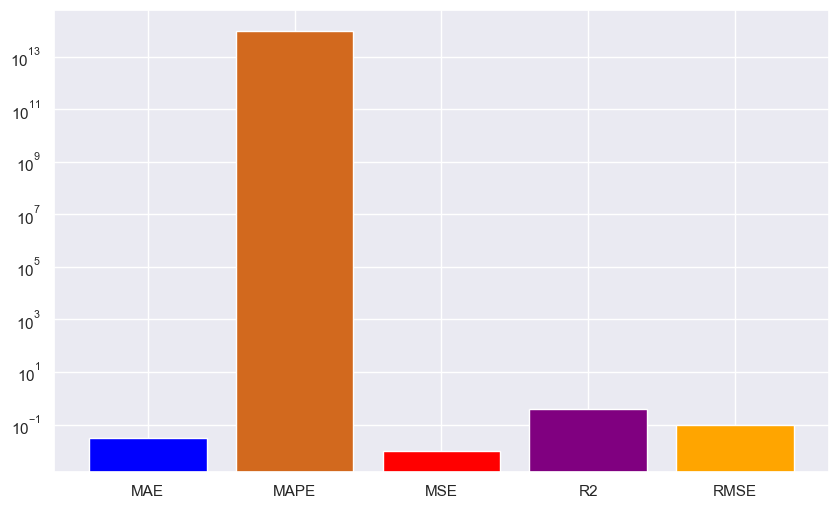

In [61]:
def plot_metricas(valores, metricas, cores):
    # Aumentando o tamanho da figura
    plt.figure(figsize=(10, 6))

    # Criando o gráfico de barras verticais
    plt.bar(metricas, valores, color=cores)

    # Aplicando escala logarítmica ao eixo y
    plt.yscale('log')

    # Exibindo o gráfico
    plt.show()

# Exemplo de uso:
valores = [0.03, 95954594991575.55, 0.01, 0.38, 0.10]
metricas = ['MAE', 'MAPE', 'MSE', 'R2', 'RMSE']
cores = ['blue', 'chocolate', 'red', 'purple', 'orange']
plot_metricas(valores, metricas, cores)

### <font color = 'CornflowerBlue'> **Verificando as Feature Importances**</font>

In [62]:
# Obter a importância das features
feature_importance = rf.feature_importances_

# Criar um DataFrame para visualização
feature_importance_df = pd.DataFrame({'Feature': X_treino.columns, 'Importance': feature_importance})

# Classificar as features pela importância em ordem decrescente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Definir a função para adicionar o background aos maiores valores
def highlight_max_values(s):
    is_max = s == s.max()
    return ['background-color: lightblue' if v else '' for v in is_max]

# Aplicar o estilo ao DataFrame
styled_feature_importance_df = feature_importance_df.style.apply(highlight_max_values, subset=['Importance'])

# Exibir o DataFrame com o background destacado
styled_feature_importance_df

,Feature,Importance
2,atm_pressure_main,0.327760
4,piezo_charge,0.261382
1,air_temperature_100,0.228883
0,air_humidity_100,0.121300
3,num_of_resets,0.060676


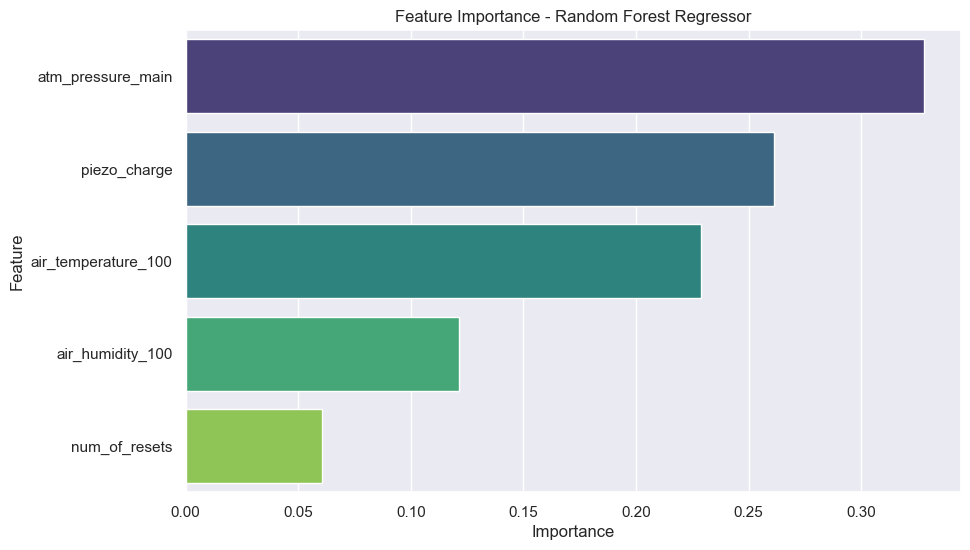

In [63]:
# Passo 3: Obter a importância das features
feature_importance = rf.feature_importances_

# Passo 4: Criar um DataFrame para visualização
feature_importance_df = pd.DataFrame({'Feature': X_treino.columns, 'Importance': feature_importance})

# Passo 5: Classificar as features pela importância em ordem decrescente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Passo 6: Plotar o gráfico de barras horizontal com cores diferentes para cada variável
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest Regressor')
plt.show()

### <font color = 'CornflowerBlue'> **Salvando o modelo**</font>

In [64]:
# Criando um modelo Pickle para ser salvo
import pickle
filename = 'senor_chuva.pkl'
pickle.dump(rf, open(filename, 'wb'))